In [13]:
import tensorflow_datasets as tfds
import tensorflow as tf
from tensorflow.keras.layers import Dense
import numpy as np
import matplotlib.pyplot as plt

In [4]:
(train_ds, test_ds), ds_info = tfds.load('mnist', split=['train', 'test'], as_supervised=True, with_info=True)

2022-11-18 17:57:00.369090: W tensorflow/core/platform/cloud/google_auth_provider.cc:184] All attempts to get a Google authentication bearer token failed, returning an empty token. Retrieving token from files failed with "NOT_FOUND: Could not locate the credentials file.". Retrieving token from GCE failed with "FAILED_PRECONDITION: Error executing an HTTP request: libcurl code 6 meaning 'Couldn't resolve host name', error details: Could not resolve host: metadata".


Dl Completed...: 100%|██████████| 4/4 [00:09<00:00,  2.33s/ file]

Dataset mnist downloaded and prepared to /Users/leonackermann/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.
Metal device set to: Apple M1 Pro

systemMemory: 32.00 GB
maxCacheSize: 10.67 GB




2022-11-18 17:57:12.761358: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-11-18 17:57:12.761820: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [5]:
# 2.2 - set up data pipiline
def prepare_mnist_data(mnist):
    # map from uint8 to tf.float
    mnist = mnist.map(lambda img, target: (tf.cast(img, tf.float32), target))

    # flatten input
    mnist = mnist.map(lambda img, target: (tf.reshape(img, (-1, )), target))
    
    # normalize input to gaussian distribution or divide by 128
    mnist = mnist.map(lambda img, target: (((img/128)-1), target))

    # encode labels as one hot vector
    mnist = mnist.map(lambda img, target: (img, tf.one_hot(target, depth=10)))

    # keep the progess in memory
    mnist = mnist.cache()
    mnist = mnist.shuffle(1000) 
    mnist = mnist.batch(32) # 32 image in one batch
    mnist = mnist.prefetch(20) # prepare 20 next datapoints 

    return mnist

In [6]:
train_dataset = train_ds.apply(prepare_mnist_data)
test_dataset = test_ds.apply(prepare_mnist_data)

In [7]:
# 2.3 - build network
class MyModel(tf.keras.Model):
    def __init__(self) -> None:
        super(MyModel, self).__init__()
        self.dense1 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.dense2 = tf.keras.layers.Dense(256, activation=tf.nn.relu)
        self.out = tf.keras.layers.Dense(10, activation=tf.nn.softmax)

    @tf.function
    def call(self, inputs):
        x = self.dense1(inputs)
        x = self.dense2(x)
        x = self.out(x)
        return x

In [8]:
# 2.4 - training the network
def train_step(model, input, target, loss_function, optimizer):

    # loss object and optimizer and are instances of respective tensorflow classes 
    with tf.GradientTape() as tape:
        prediction = model(input)
        loss = loss_function(target, prediction)
    gradients = tape.gradient(loss, model.trainable_variables) # all variables with trainable = True
    optimizer.apply_gradients(zip(gradients, model.trainable_variables)) # updating weights with optimizer
    return loss

# 2.4.1 - testing the model
def test(model, test_data, loss_function):

    test_accuracy_aggregator = []
    test_loss_aggregator = [] # continuous

    # input is batch of 32 examples
    for (input, target) in test_data:
        prediction = model(input)
        sample_test_loss = loss_function(target, prediction)
        sample_test_accuracy = np.argmax(target, axis=1) == np.argmax(prediction, axis=1)
        sample_test_accuracy = np.mean(sample_test_accuracy)
        test_loss_aggregator.append(sample_test_loss.numpy())
        test_accuracy_aggregator.append(np.mean(sample_test_accuracy))

    test_loss = tf.reduce_mean(test_loss_aggregator)
    test_accuracy = tf.reduce_mean(test_accuracy_aggregator)

    return test_loss, test_accuracy

In [14]:
# 2.5 - visualization
def visualization ( train_losses , test_losses , test_accuracies ):
    """
    Visualizes accuracy and loss for training and test data using the mean of each epoch. 
    Loss is displayed in a regular line , accuracy in a dotted line. 
    Training data is displayed in blue , test data in red .

    Parameters
    ----------
    train_losses : numpy . ndarray
    training losses
    train_accuracies : numpy . ndarray
    training accuracies
    test_losses : numpy . ndarray
    test losses
    test_accuracies : numpy . ndarray
    test accuracies
    """


    plt . figure ()
    line1 , = plt. plot ( train_losses , "b-")
    line2 , = plt. plot ( test_losses , "r-")
    #line3 , = plt. plot ( train_accuracies , "b:")
    line4 , = plt. plot ( test_accuracies , "r:")
    plt . xlabel (" Training steps ")
    plt . ylabel (" Loss / Accuracy ")
    plt . legend (( line1 , line2 , line4 ), (" training loss ", " testloss ", " test accuracy "))
    plt . show ()

In [10]:
# Running the network
# Training
epochs = 10
learning_rate = 0.001

model = MyModel()
cross_entropy_loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate)

# for visualization
train_losses = []
test_losses = []
test_accuracies = []

# test model before training
test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
test_losses.append(test_loss)
test_accuracies.append(test_accuracy)

train_loss, _ = test(model, train_dataset, cross_entropy_loss)
train_losses.append(train_loss)

for epoch in range(epochs):
    print(f'Epoch: {str(epoch)} starting with accuracy {test_accuracies[-1]}')

    # training 
    epoch_loss_agg = []
    for input, target in train_dataset:
        train_loss = train_step(model, input,target, cross_entropy_loss, optimizer)
        epoch_loss_agg.append(train_loss)

    # track training loss
    train_losses.append(tf.reduce_mean(epoch_loss_agg))

    # track accuracy and test loss
    test_loss, test_accuracy = test(model, test_dataset, cross_entropy_loss)
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

visualization(train_losses, test_losses, test_accuracies)

    

2022-11-18 18:10:17.376660: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-11-18 18:10:17.587628: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-18 18:10:19.631671: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch: 0 starting with accuracy 0.15724840255591055


2022-11-18 18:10:29.153590: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2022-11-18 18:10:29.361034: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch: 1 starting with accuracy 0.8601238019169329
Epoch: 2 starting with accuracy 0.889576677316294
Epoch: 3 starting with accuracy 0.8995607028753994
Epoch: 4 starting with accuracy 0.9047523961661342
Epoch: 5 starting with accuracy 0.9123402555910544
Epoch: 6 starting with accuracy 0.9153354632587859
Epoch: 7 starting with accuracy 0.919029552715655
Epoch: 8 starting with accuracy 0.9221246006389776
Epoch: 9 starting with accuracy 0.9254193290734825


TypeError: visualization() missing 1 required positional argument: 'test_accuracies'

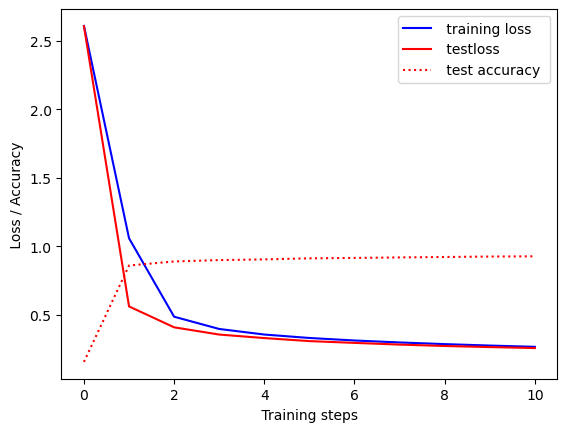

In [15]:
visualization(train_losses, test_losses, test_accuracies)
